<a href="https://colab.research.google.com/github/Sung4ji3/comp215/blob/main/labs/lab06_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6
----------------
#### Name(s): Marcus Leung
#### Date:

By the end of this lab you should be able to:
  * create a Watts-Strogatz graph both from scratch and from the Networkx module
  * measure the average clustering coefficient and path length of a network
  * visualize summative data of a graph


During this lab, you will be introduced to the following:
  * numpy arrays
  * local file i/o in Google Colab

(this lab is based on workbooks provided in Allen Downey's 'Think Complexity')

## Social Networking

This lab uses graphs to explore social networks using Facebook data.  In this lab you will create a simulated model of the network using a Watts-Strogatz graph and compare some properties of the simulated network and the real Facebook network.

In [2]:
# put your imports here

In [3]:
import numpy as np
import networkx as nx
import random as rdm
from collections import deque
from pprint import pprint

## Get the Facebook Data

Stanford Network Analysis Platform (SNAP) is a general purpose network analysis and graph mining library.  In previous labs, we have used APIs to access data.  For this lab, we will copy the data to a local file.  Download the ```facebook_combined.txt.gz``` file from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html), unzip it, and copy ```facebook_combined.txt``` to the ```Files``` folder in Colab.  

Look at the content of the file and read the SNAP webpage to understand what the data represents before moving on to the rest of the lab.

## Exercise 1: Make Facebook Graph

Write a function that reads the file, one edge per line, specified by the two integer node IDs given in each line of the file and returns a ```networkx``` graph representing the data.  You can do this with Python's built-in file handling, or you could use ```numpy```'s ```loadtxt``` function.  Write a unit test to check that the network has 4039 nodes and 88234 edges (as given in the Dataset Statistics on the SNAP site) and draw the Facebook network (this takes about a minute).


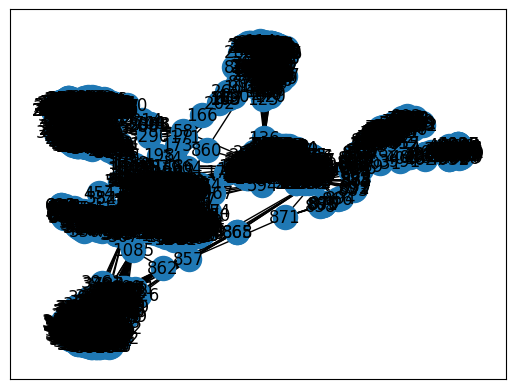

In [4]:
text = np.loadtxt("/content/facebook_combined.txt", dtype=str)
uniqueusers = list(set([element for row in text for element in row]))
friendships = [row for row in text]
def converttograph(userslist, connections):
  """Given the SNAP list of facebook users and existing connections between the users, returns a node-edge graph object representing the network of users."""
  G = nx.Graph()
  G.add_nodes_from(userslist)
  G.add_edges_from(connections)
  assert len(list(G.nodes)) == 4039
  assert len(list(G.edges)) == 88234
  return G

G = converttograph(uniqueusers, friendships)
nx.draw_networkx(G)

## Exercise 2: Clustering Coefficients

With larger graphs, it can take a long time to compute clustering coefficients and path lengths. We can estimate them by sampling without much loss of accuracy if the sample size is large enough.  Write a function that calculates the average clustering coeffient for a random subset of a N nodes in a network.  You may use the ```node_clustering``` and ```all_pairs``` functions from Chapter 5 of the textbook.  You may also use the ```numpy``` module to calculate the mean; note that there is a ```nanmean``` function.

Check that your clustering coeffients function gives a similar answer to the ```networkx``` ```average_clustering``` function.


In [5]:
def all_pairs(nodes):
  """Given an iterable consisting of string names representing nodes, subsequently return each possible pair combination of nodes."""
  for i, u in enumerate(nodes):
      for j, v in enumerate(nodes):
          if i>j:
              yield u, v

def node_clustering(graph, specificnode):
  """Given a graph object and the name of a specific node, return the clustering coefficient of the specific node relative to its neighbors."""
  neighbors = graph[specificnode]
  k = len(neighbors)
  if k < 2:
    return np.nan
  else:
    possible = k * (k-1) / 2
    exist = 0
    for v, w in all_pairs(neighbors):
      if graph.has_edge(v, w):
        exist +=1
    return exist / possible

def avgclustcoeff(graph, randsubset):
  """Given a graph object and a list containing a randomly-determined-amount of nodes, return the mean value of all clustering coefficients given when every node in the list is inputted into a clustering coefficient algorithm. This return-value represents the average clustering coefficient for every node in the given graph."""
  clustcoeffs= [node_clustering(graph, node) for node in randsubset]
  mean = np.nanmean(clustcoeffs)
  return(mean)

randsubset4039 = rdm.sample(uniqueusers, 4039)
print(avgclustcoeff(G, randsubset4039))


0.6170038336292958


In [6]:
print(nx.average_clustering(G))

0.6055467186200868


## Exercise 3: Average Shortest Path Length

Write a function that calculates the average shortest path length for all pairs of nodes in a network.  You may use the ```shortest_path_dijkstra``` function from Chapter 5 of the textbook.  Using that function, it took my algorithm about 2 minutes to find the average shortest path over all pairs of nodes.


Check that your average shortest path length function gives a similar answer to the ```networkx``` ```average_shortest_path_length``` function.


In [19]:
def shortest_path_dijkstra(graph, source):
  """Given a graph object and a specific node in the graph, returns the minimum distance from the specific node to every other node in the graph."""
  dist = {source: 0}
  queue = deque([source])
  while queue:
    node = queue.popleft()
    new_dist = dist[node] + 1
    neighbors = set(graph[node]).difference(dist)
    for n in neighbors:
        dist[n] = new_dist
    queue.extend(neighbors)
  return dist


def avgshortestpathlen(graph, node):
  """Given a node-graph and the string name of a specific node in the graph, collect each minimum path-length from the specific node to every other node, and return the mean-average of the entire collection."""
  strtointdict = shortest_path_dijkstra(graph, node)
  pathlenlist = [strtointdict[key] for key in strtointdict]
  mean = np.nanmean(pathlenlist)
  return mean

allnodeavgs = [avgshortestpathlen(G, node) for node in uniqueusers]
meanofall = np.nanmean(allnodeavgs)
print(meanofall)

3.691592636562027


In [18]:
print(nx.average_shortest_path_length(G, 10))

3.6925068496963913


Here is a function from the textbook that takes a sample of path lengths to estimate the average shortest path length.  You may use this in the rest of the lab so that you don't need to wait for the whole full averaging algorithms above to run.

In [ ]:

def sample_path_lengths(G, nodes=None, trials=100):
    """Choose random pairs of nodes and compute the path length between them.
    G: Graph
    N: number of pairs to choose
    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

In the exercises above, you should have found that the Facebook network has an average clustering coefficient around 0.6 and an average shortest path length of around 3.7. Note that this corresponds to a 'degree of separation' of less than 6.   

## Exercise 4: WS Graph

Construct a WS graph with the same number of nodes and average degree as the Facebook network using the ```make_ws_graph``` function from Chapter 5.  Find the value of p (probability of rewire) that reproduces a clustering coefficient and average shortest path length of the Facebook network.  (Note that there is a ```nx.watts_strogatz_graph``` that you may use after you have demonstrated that you can create a WS graph using the functions from Chapter 5.).

What could this value of p tell you about the actual social network that this Facebook data represents?  (Think about what p means in the model and what that would represent in the data.)

In [28]:
import matplotlib.pyplot as plt

import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py

%matplotlib inline

from utils import decorate

def flip(p):
  """Given probability p, returns boolean that, if true, edge gets rewired."""
  return np.random.random() < p

def rewire(graph, p):
  """"""
  nodes = set(graph)
  for u, v in graph.edges():
    if flip(p):
      choices = nodes - {u} - set(graph[u])
      new_v = np.random.choice(list(choices))
      graph.remove_edge(u, v)
      graph.add_edge(u, new_v)

def adjacent_edges(nodes, halfk):
  """"""
  n = len(nodes)
  for i, u in enumerate(nodes):
    for j in range(i+1, i+halfk+1):
      v = nodes[j % n]
      yield u, v

def make_ring_lattice(n, k):
  """"""
  graph = nx.Graph()
  nodes = range(n)
  graph.add_nodes_from(nodes)
  graph.add_edges_from(adjacent_edges(nodes, k//2))
  return graph

def all_pairs(nodes):
  """Generates all pairs of nodes."""
  for i, u in enumerate(nodes):
      for j, v in enumerate(nodes):
          if i < j:
              yield u, v

def path_lengths(graph):
  """takes a graph and returns a list of shortest path lengths, one for each pair of nodes."""
  length_map = nx.shortest_path_length(graph)
  lengths = [length_map[u][v] for u, v in all_pairs(graph)]
  return lengths


def characteristic_path_length(graph):
  return np.mean(path_lengths(graph))

def make_ws_graph(n, k, p):
  """Makes a Watts-Strogatz graph.
  n: number of nodes
  k: degree of each node
  p: probability of rewiring an edge
  """
  ws = make_ring_lattice(n, k)
  rewire(ws, p)
  return ws

def clustering_coefficient(graph):
  """Average of the local clustering coefficients.
  returns: float
  """
  cu = [node_clustering(graph, node) for node in graph]
  return np.nanmean(cu)

def run_one_graph(n, k, p):
  ws = make_ws_graph(n, k, p)
  mpl = characteristic_path_length(ws)
  cc = clustering_coefficient(ws)
  return mpl, cc

def run_experiment(ps, n, k, iters=20):
  res = []
  for p in ps:
    t = [run_one_graph(n, k, p) for _ in range(iters)]
    means = np.array(t).mean(axis=0)
    res.append(means)
  return np.array(res)


ps = np.logspace(-4, 0, 9)

n = 4093

k = 8

res = run_experiment(ps, n, k)

L, C = np.transpose(res)

L /= L[0]
C /= C[0]

plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

plt.show()

TypeError: 'generator' object is not subscriptable